# <center>  Python for biologists

## Lecture 22 - 23: Инструменты разработчика

05.04.2025, 12.04.2025


---

# Профилирование

**Профилирование** - это сбор некоторых характеристик о работе программы. Что это могут быть за характеристики и как их собирать - мы сегодня и разберём. Цели, для достижения которых применяют профилирование (как один из шагов):
 
 + Оптимизация и повышение производительности
 + Поиск критических мест и уязвимостей
 
 
Можно выделить 3 метрики, доступные для нас в рамках профилирования:
1) Время выполнения программы
2) Память затраченная на выполнение программы
3) Логика выполнения программы (порядок операций)

Давайте для примера попробуем отпрофилировать функцию ниже и понять что-же с ней не так (хотя может вы и так видите)

In [1]:
def sum_to_n(n):
    start = 1
    end = int(n) + 1
    numbers = list(range(start, end))
    return sum(numbers)

In [2]:
sum_to_n(4) # 1 + 2 + 3 + 4

10

## 1) Время выполнения

Существует бесчисленное множество профилировщиков времени, здесь мы выпишем самые доступные и простые

+ `time` и `perf_counter` из модуля `time`
+ `timeit` из модуля `timeit`
+ `time`из модуля `datetime`
+ Unix `time`
+ Magic Jupyter `%%time` и `%%timeit`
+ CProfile (его мы разберем в части 3)

### Модуль `time`


#### `time.time`

Это самый простой и понятный способ профилирования - замер времени которое прошло с момента начала и до конца выполнения программы (или отдельного её фрагмента). В самом базовом случае достаточно воспользоваться функцией `time` из встроенного модуля `time` (скорее всего вы ей и пользовались в контекстном менеджере `MeasureTime`)

In [3]:
import time

In [4]:
start_time = time.time()
res = sum_to_n(5e7)
end_time = time.time()

print(res, f'Elapsed time {end_time - start_time:.7g} sec.')
print(type(end_time - start_time))

1250000025000000 Elapsed time 2.054909 sec.
<class 'float'>


#### `time.perf_counter`

Функция  `perf_counter` из модуля `time` позволяет измерить время выполнения с большей точностью. Это связано с тем, что по сути `time.time` это просто обертка (API) для доступа к системным часам вашей машины. Любые сбои с системными часами или проблемы доступа к ним могут повлиять на результат профилирования.  В то же время `perf_counter` создает свой собственный счетчик.

Говорят он работает точнее, хотя плата за это - немного некрасивое название :)

In [5]:
start_time = time.perf_counter()
res = sum_to_n(5e7)
end_time = time.perf_counter()

print(res, f'Elapsed time {end_time - start_time:.7g} sec.')
print(type(end_time - start_time))

1250000025000000 Elapsed time 1.491507 sec.
<class 'float'>


#### Разное другое из `time`

Также в модуле `time` имеется много других интрументов. Например, `perf_counter_ns` возвращает время в наносекундах, а `monotonic` работает как `perf_counter` но с более редкой дискретизацией (подходит для больших программ). Также есть функции `process_time` и `thread_time`, полезные для профилирования процессов и потоков, но про них мы поговорим на одной из следующих лекций.

### Модуль `timeit`

#### `timeit.timeit`

Эта функция принимает на вход функцию (без аргументов) или фрагмент кода (в виде строки) и выводит среднее время выполнения по итогу заданного числа итераций

In [6]:
import timeit

In [7]:
timeit.timeit(lambda: sum_to_n(5e7), number=5)

5.650313397000048

### Модуль `datetime`

#### `datetime.time`

Эта функция аналогична `time.time`, но:

- В момент записи сохраняет не только время но и дату
- Разность записей это не просто число, а объект типа `datetime.timedelta`
- Все эти штуки можно еще по разному форматировать, брать относительно выбранного часового пояса и т.п.

In [8]:
import datetime

In [9]:
start_time = datetime.datetime.now()
res = sum_to_n(5e7)
end_time = datetime.datetime.now()

print(f'Started at {start_time}')
print(f'Ended at {end_time}')
print(f'Elapsed time {end_time - start_time}')
print(type(end_time - start_time))

Started at 2025-04-05 13:58:03.926754
Ended at 2025-04-05 13:58:05.076652
Elapsed time 0:00:01.149898
<class 'datetime.timedelta'>


### Unix `time`

Работая в  терминале и запуская разные тулы или скрипты, вы можете замерить время их работы с помощью консольной утилиты `time`

In [10]:
%%file some_script.py 
# записывает содержимое ячейки в файл
def sum_to_n(n):
    start = 1
    end = int(n) + 1
    numbers = list(range(start, end))
    return sum(numbers)

print(sum_to_n(5e7))

Writing some_script.py


In [11]:
! time python some_script.py

1250000025000000
python some_script.py  0.62s user 1.22s system 91% cpu 2.003 total


Как видите, здесь нам начала появляться некоторая дополнительная информация. Чуть ниже будет разобрано что это значит.

+ Magic Jupyter `%%time` и `%%timeit`

Эти две магические команды Jupyter позволяют замерить время выполнения ячейки аналогично консольной утилите `time` и модулям `time` и `timeit`). Первая замеряем время однократно, а вторая усредняет по несколькими итерациями).

In [12]:
%%time

sum_to_n(5e7)

CPU times: user 557 ms, sys: 712 ms, total: 1.27 s
Wall time: 1.27 s


1250000025000000

In [13]:
%%timeit

sum_to_n(5e7)

1.11 s ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit -r 10

sum_to_n(5e7)

1.22 s ± 280 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Их также можно использовать не на уровне "магической ячейки" (`%%`), а на уровне лишь одной магической строки (`%`)

In [15]:
time.sleep(1)

%time sum_to_n(5e7)

time.sleep(1)

CPU times: user 520 ms, sys: 511 ms, total: 1.03 s
Wall time: 1.12 s


Видим что строки сна до и после не повлияли на замер.

При этом весь код пробегает за 1.4 секунды, что может быть и не так много для такой большой суммы чисел. Пока непонятно, есть ли вообще какая-то проблема.

### Что означают разные времена в юниксовом и юпитеровском `time`?


- **`Wall time`**

    Это попросту полное время "от и до" которое затратилось на выполнение программы. При этом программа могла спать или просто простаивать (например, ожидая ввода с клавиатуры). По сути это время которое прошло для человека сидящего за компом (и смотрящего на часы на стене).

- **`CPU times`**

    Это то время, которое процессор непосредственно совершал работу. При этом оно разделяется на 2 типа

    - `user` - относится к пользовательскому режиму, выполнение операций с объектами пользователя (например, итерация по массиву лежащему в оперативке)

    - `sys` - относистся к системному (kernel, privileged) режиму, это время которое процессор потратил обращаясь к операционной системе.

    - `total` - это сумма `system` + `user`


Чаще всего для вас `Wall time` будет примерно равно `total CPU`, либо несколько больше (если были промежутки простоя и ожидания). 


> Тем не менее, иногда `total CPU time` (сколько работал процессор) может оказаться в разы больше `Wall time` (сколько ждал человек). </br>
> ***Как такое может быть?*** 

Такое может быть, если на вашей машине есть несколько ядер, которые параллельно выполняют некоторую работу (поэтому оно и называется `CPU timeS`)


Представим такой пример: у вас есть 10 файлов которые вам нужно прочитать и как то обработать. Допустим системе нужно 2 секунды, чтобы прочитать файл в оперативку и 5 секунд чтобы обработать данные. В таком случае результат профилирования времени будет выглядеть так:

```python
CPU times: user 50 s, sys: 20 s, total: 70 s
Wall time: 70 s
```

Здесь мы 2*10 секунд читали 10 файлов и 5*10 секунд обрабатывали каждый из них. 

А теперь если мы запутим это дело в 10 потоков:

```python
CPU times: user 50 s, sys: 20 s, total: 70 s
Wall time: 7 s
```

То есть процессоро-секунды были затрачены те же самые, но за счет параллельного выполнения мы как программист за компом ждали всего 7 секунд вместо 70.

## 2) Затраченная память 

Здесь в случае с python наиболее простым и удобным является `memory_profiler` и мы рассмотрим только его. В доп. ссылках ниже будут какие-то еще более продвинутые примеры.

### `memory_profiler`

Это один из самых популярных профилировщиков затраченной памяти. Обычно его запускают как скрипт через `python -m memory_profiler some_script.py` подавая на вход программу для анализа, однако есть и расширение в виде магической ячейки в юпитер-ноутбуке (только здесь `it` не значит "итеративно", а значит "это")

In [17]:
%reload_ext memory_profiler

In [18]:
%%memit 

sum_to_n(5e7)

peak memory: 1993.58 MiB, increment: 1913.30 MiB


На этом моменте становится понятно, что проблема действительно есть, наша программа под капотом жрет около 2х гигов памяти! И это чтобы просто сложить числа. Что-то тут не так (хотя пока не понятно что). Для этого есть очень полезный декоратор `@profile` который может многими библиотеками использоваться как указание на то что данную функцию надо распрофилировать более детально.

In [19]:
%%file some_script.py 

@profile
def sum_to_n(n):
    start = 1
    end = int(n) + 1
    numbers = list(range(start, end))
    return sum(numbers)

print(sum_to_n(5e7))

Overwriting some_script.py


In [20]:
! python -m memory_profiler some_script.py

1250000025000000
Filename: some_script.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     2   50.152 MiB   50.152 MiB           1   @profile
     3                                         def sum_to_n(n):
     4   50.152 MiB    0.000 MiB           1       start = 1
     5   50.152 MiB    0.000 MiB           1       end = int(n) + 1
     6 1963.461 MiB 1913.309 MiB           1       numbers = list(range(start, end))
     7 1963.461 MiB    0.000 MiB           1       return sum(numbers)




Вот это уже супер, мы видим что скачок до 2х гигов по памяти произошел на определенной строчке кода. Да, рассматривать код по-строчно очень полезно!

### А что такое `MiB`?

Почему `memory_profiler` приводит память в такой вроде понятной а вроде и непонятной единице измерения? По идее это что-то похожее на мегабайты, но ведь это не может быть м**И**габайты. Верно, не может.

Вопрос, а **сколько килобайт в одном мегабайте?**

Если вы ответили 1024, поздравляю, видимо вы учились в школе на информатике на пятерки:). Возможно те кто учились на пятерки не на информатике, а на физике, подумали что в мегабайте 1000 килобайт. 


В любом случае, правильный вариант именно второй (*ЧТО?!*). 

Да. Изначально была проблема с тем, что все в нашем компьютерном мире было двоичным и исчислялось в степенях двойки. Так и мегабайты, считали как $2^{20} = 1024$ килобайтов. Однако со временем люди поняли, что это не очень удобно. Мы с вами существа десятиричные, и во всех науках, особенно в физике и математике, *мега* означает $10^3$, а не $2^{20}$. Поэтому информатику так же решили подогнать под одну гребёнку. 

Поэтому теперь 1 мегабайт это 1000 килобайт. 

А как же быть с тем что у нас всё двоичное? В общем чтобы совсем не обижать информатиков и сохранить обратную совместимость, им даровали другой набор приставок, специально для степеней двойки:

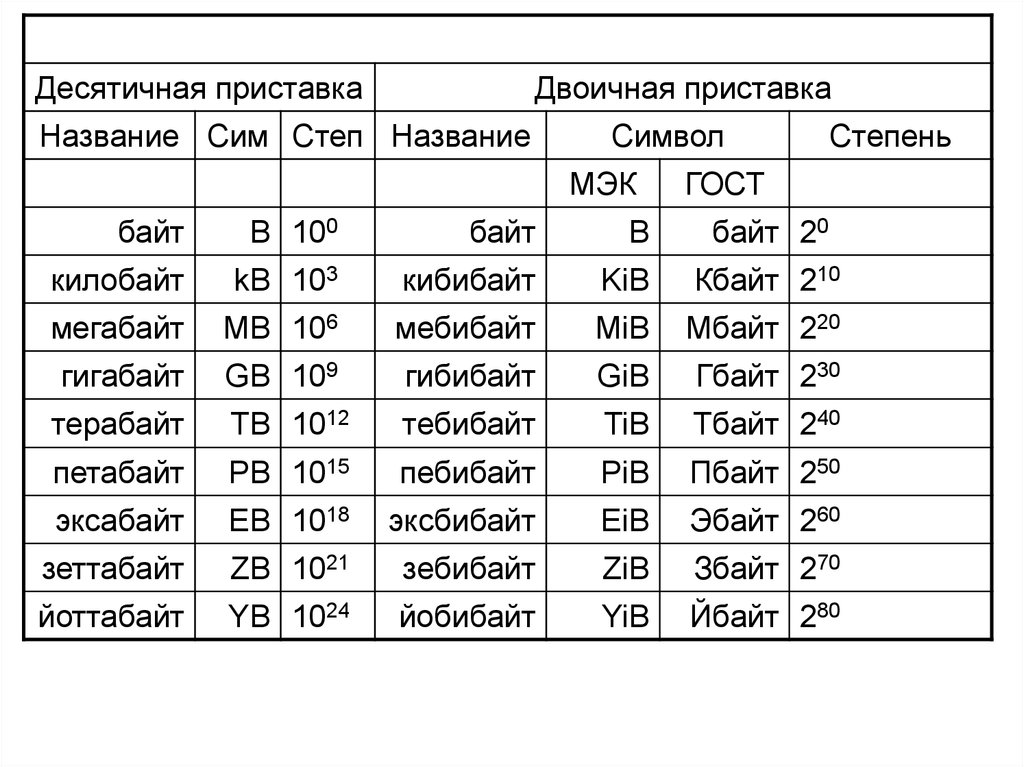

## 3) Логика выполнения

Как вы могли понять, самую полезную информацию мы можем получить, разбирая нужные участки кода построчно. Как раз для этого есть более продвинутые тулы, которые позволяют проследить в каком порядке какие строки кода выполняются, не происходит ли рекурсий и вечных циклов и т.п. С двумя самыми простейшими интрументами к слову вы уже знакомы)

- Любой дебаггер
- [PythonTutor](https://pythontutor.com/)

Тем не менее, для этого есть и специальные инструменты:
- `CProfile`
- `dis`

### `cProfile`

Эта утилита позволяет проанализировать какие задачи выполняла программа и какое время было затрачено на выполнение каждой из них. И плюсом и минусом этого подхода является то, что мы смотрим именно не на отдельные строки, а на отдельные задачи. Одна задача (например, вызов функции) может состоять из нескольких строк кода, так и на одной строке кода может быть выполнено несколько задач. 

Этой утилитой можно воспользоваться и в качестве модуля в python, но в Юпитер-ноутбке это даст кучу лишних технических штук.

```python
import cProfile
cProfile.run('sum_to_n(5e7)')
```

Снова создадим скрипт и пропрофилируем его c помощью `cProfile`

In [21]:
%%file some_script.py 

def sum_to_n(n):
    start = 1
    end = int(n) + 1
    numbers = list(range(start, end))
    return sum(numbers)

print(sum_to_n(5e7))

Overwriting some_script.py


In [22]:
! python -m cProfile some_script.py

1250000025000000
         6 function calls in 2.241 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.241    2.241 {built-in method builtins.exec}
        1    0.398    0.398    2.241    2.241 some_script.py:1(<module>)
        1    1.424    1.424    1.842    1.842 some_script.py:2(sum_to_n)
        1    0.419    0.419    0.419    0.419 {built-in method builtins.sum}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Здесь мы видим количество вызова каждой функции и сколько секунд занял тот или иной вызов.

- `ncalls` - счетчик вызовов, полезен для профилирования рекурсивных функций
- `tottime` - время проведённое "внутри" этой функции ***не включая*** время проведённое во внутренних под-функциях если есть
- `percall` - `tottime` поделенное на `ncalls`
- `cumtime` - время проведенное "внутри" этой функции ***включая*** все внутренние под-функции
- `percall` - `cumtime` поделенное на `ncalls`

Немного модифицируем нашу функцию чтобы понять что не так:

In [23]:
%%file some_script.py 

def make_numbers(start, end):
    return list(range(start, end))

def sum_to_n(n):
    start = 1
    end = int(n) + 1
    numbers = make_numbers(start, end)
    return sum(numbers)

print(sum_to_n(5e7))

Overwriting some_script.py


In [24]:
! python -m cProfile some_script.py

1250000025000000
         7 function calls in 1.762 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.762    1.762 {built-in method builtins.exec}
        1    0.288    0.288    1.762    1.762 some_script.py:1(<module>)
        1    0.000    0.000    1.474    1.474 some_script.py:5(sum_to_n)
        1    1.265    1.265    1.265    1.265 some_script.py:2(make_numbers)
        1    0.210    0.210    0.210    0.210 {built-in method builtins.sum}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Теперь мы еще более наглядно видим, что большую часть времени из 1.5 секунды мы тратим не на суммирование чисел (`built-in method builtins.sum}`; что было нашей задачей), а на их создание (`some_script.py:2(make_numbers)`) 

Почему так? Что же вообще происходит? 


### `dis`

Функция `dis` из модуля `dis` позволяет добавиться до самого низкого уровня и разобрать выполнение байткода нашей программы.

Она выдает результат в виде таблички с 7 колонками:

1) Адрес (номер строки) в исходном текстовом файле кода (не уверен как это работает в случае с юпитером)
2) *Опционально* номер текущей инструкции
3) Обозначает наличие прыжка (`jump`) в это место из какого-нибудь другого места, например, вложенности, рекурсии, условия и т.п. (если имеется)
4) Адрес в байткоде 
5) Название текущей операции
6) Некоторые аргументы / индексы, которые можно трактовать в зависимости от значений в других полях
7) Человекочитаемая доп. подсказка

Узнать про это поподробнее можно из этой [ветки](https://stackoverflow.com/questions/12673074/how-should-i-understand-the-output-of-dis-dis) на StackOverflow и из [этого](https://www.youtube.com/watch?v=7WawuzR0rMs) видоса на ютубе.

In [25]:
import dis

In [26]:
dis.dis(sum_to_n)

  1           0 RESUME                   0

  2           2 LOAD_CONST               1 (1)
              4 STORE_FAST               1 (start)

  3           6 LOAD_GLOBAL              1 (NULL + int)
             18 LOAD_FAST                0 (n)
             20 PRECALL                  1
             24 CALL                     1
             34 LOAD_CONST               1 (1)
             36 BINARY_OP                0 (+)
             40 STORE_FAST               2 (end)

  4          42 LOAD_GLOBAL              3 (NULL + list)
             54 LOAD_GLOBAL              5 (NULL + range)
             66 LOAD_FAST                1 (start)
             68 LOAD_FAST                2 (end)
             70 PRECALL                  2
             74 CALL                     2
             84 PRECALL                  1
             88 CALL                     1
             98 STORE_FAST               3 (numbers)

  5         100 LOAD_GLOBAL              7 (NULL + sum)
            112 LOAD_FAST  

Предлагаю вам самостоятельно попробовать разобрать то что здесь происходит. Если мы не успеем сделать это на лекции, то можно будет на консультации или в чате)

## Исправляем функцию


Наверное вы уже поняли что с функцией было не так, мы там сделали лишную сборку чисел из генератора `range` в список, из-за чего программа тратила сильно больше памяти.

In [27]:
%%file some_script.py 

def sum_to_n(n):
    start = 1
    end = int(n) + 1
    numbers = range(start, end)
    return sum(numbers)

print(sum_to_n(5e7))

Overwriting some_script.py


In [28]:
! python -m cProfile some_script.py

1250000025000000
         6 function calls in 0.385 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.385    0.385 {built-in method builtins.exec}
        1    0.000    0.000    0.385    0.385 some_script.py:1(<module>)
        1    0.000    0.000    0.385    0.385 some_script.py:2(sum_to_n)
        1    0.385    0.385    0.385    0.385 {built-in method builtins.sum}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [30]:
def sum_to_n(n):
    start = 1
    end = int(n) + 1
    numbers = range(start, end)
    return sum(numbers)

In [31]:
%%memit 

sum_to_n(5e7)

peak memory: 80.81 MiB, increment: 0.00 MiB


Отлично! Теперь наша функция стала работать в 2 раза быстрее и занимает в разы меньше места:)

## Два важных совета

- Многие профилировщики отталкиваются от того какие функции есть в вашем коде. Если вы не понимете что идет не так, дополнительно разбивайте ваш на код на функции (как мы это сделали с генерацией чисел) чтобы лучше подсвятить проблемное место
- Избегайте применения разных инструментов одновременно, так как они могут очень значительно влиять друг на друга.

## Дополнительные тулы для профилирования

Если вам интересны какие-то допольнительные сторонние либы, можете обратить внимание на [line_profiler](https://github.com/pyutils/line_profiler) и [pyheat](https://github.com/csurfer/pyheat), которые отображают сколько времени выполнялась каждая из строк кода. Также есть много и других интересных, например [scalene](https://github.com/plasma-umass/scalene), [https://github.com/joerick/pyinstrument](pyinstrument). В целом в области разработки есть не то что библиотеки, а отдельные огромные фреймворки для анализа кода, например, [Valgrind](https://valgrind.org/) или [Intel VTune Amplifier](https://habr.com/ru/companies/intel/articles/162521/)

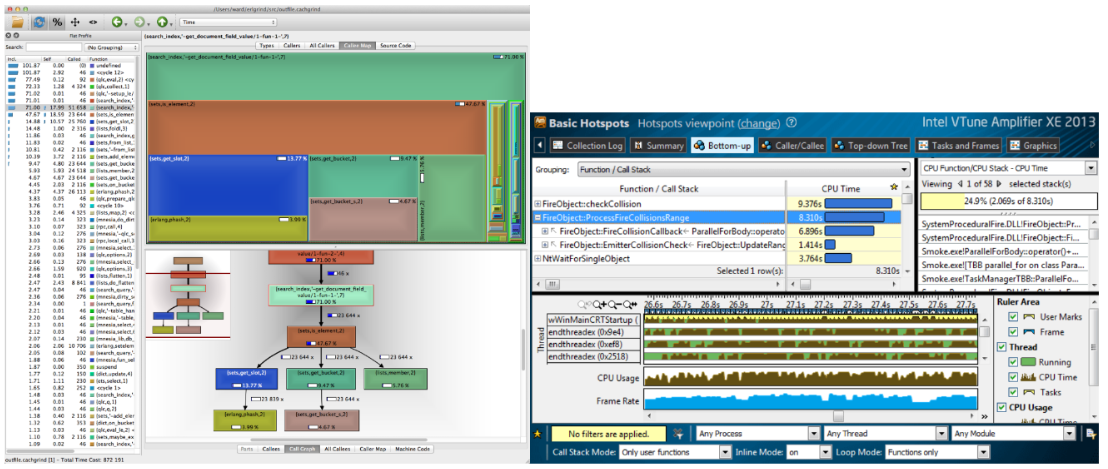


# Прием аргументов командной строки

Это одна из самых практически полезных частей этой лекции для студентов ИБ, ведь некоторые из вас действительно будут писать свои скрипты, которым надо уметь принимает какие-то аргументы из коммандной строки. 

Например, как это выглядит у `samtools`:

```bash
samtools view -h -O sam --write-index in.bam -o out.sam.gz
```
Здесь мы сразу можем выделить у аргументов несколько характеристик

- Для некоторых важно лишь наличие (`-h`), а некоторые подразумевают передачу соотвествующего значения (`-o out.sam.gz`)
- Некоторые начинаются с `-` и имеют однобуквенное имя (`-h`), а некоторые с `--` и многобуквенное (`--write-index`). При этом зачастую для аргумента может иметься оба варианта использования


Отдельно замечу, что работа с аргументами командной строки означает умение не только их принимать, но и удобство получения документации по аргументам и т.п.


Для приема аргументов командной строки в `python` можно выделить 3 библиотеки разной степени продвинутости

+ `sys` и функция `argv` - самый простой и примитивный способ, тут мы его опустим
+ `argparse` - встроенный модуль, который рассмотрим наиболее подробно
+ `click` - сторонняя библиотека, наиболее популярная во всяких бытовых приложениях на питоне



## `argparse`

Для приема аргументов с помощью этого модуля необходимо создать экземпляр класса `argparse.ArgumentParser`. При инициализации можно дополнительно указать некоторые параметры вашей программы, преимущественно необходимые для отображения в help. Созданный экземляр будет обладать набором методов, необходимых для взаимодействия с аргументами комменданой строки.

In [32]:
%%file some_script.py
import argparse

parser = argparse.ArgumentParser(
                    prog='My wonderful parser',
                    description='This tool is needed to parse command line arguments',
                    epilog='Text at the bottom of help')

parser.add_argument('positional', type=str, help='This is a positional obligatory argument (takes value)')
parser.add_argument('-k', '--keyword', help='This is a keyword optional argument (takes value)')
parser.add_argument('-f', '--flag', action='store_true', help='This is a flag, which is True if passed (False otherwise)')
parser.add_argument("-c", "--choice", choices=("choice1", "choice2"), default="choice1", 
                    help="This is optional argument with pre-defined options and default value") 
parser.add_argument('-n', '--smt-else', nargs=4, help='How many arguments shoul be passed?')

if __name__ == '__main__':
    args = parser.parse_args()
    print(args)

Overwriting some_script.py


Для `nargs` доступно несколько вариантов:

- `int` - целое число (строго сколько)
- `?` - 0 или 1
- `*` - сколько угодно
- `+` - сколько угодно, но не 0


In [33]:
! python some_script.py -h

usage: My wonderful parser [-h] [-k KEYWORD] [-f] [-c {choice1,choice2}]
                           [-n SMT_ELSE SMT_ELSE SMT_ELSE SMT_ELSE]
                           positional

This tool is needed to parse command line arguments

positional arguments:
  positional            This is a positional obligatory argument (takes value)

options:
  -h, --help            show this help message and exit
  -k KEYWORD, --keyword KEYWORD
                        This is a keyword optional argument (takes value)
  -f, --flag            This is a flag, which is True if passed (False
                        otherwise)
  -c {choice1,choice2}, --choice {choice1,choice2}
                        This is optional argument with pre-defined options and
                        default value
  -n SMT_ELSE SMT_ELSE SMT_ELSE SMT_ELSE, --smt-else SMT_ELSE SMT_ELSE SMT_ELSE SMT_ELSE
                        How many arguments shoul be passed?

Text at the bottom of help


In [34]:
! python some_script.py 'Positional' -k 'Keyword value' -f -c 'choice2' -n 1 2 3 4

Namespace(positional='Positional', keyword='Keyword value', flag=True, choice='choice2', smt_else=['1', '2', '3', '4'])


## `click`

Это стрононняя библиотека, её синтаксис очень отличается от `argparse`. В этом случае мы определяем приём аргументов с помощью специальных декораторов с параметрами. 

Мы не будем в неё погружаться, если она вам покажется интересной вы с нынешними знаниями легко сможете сделать это сами. Я лишь хотел показать, как одну и ту же задачу (прием аргументов) решили двумя разными способами: 1) создание экземляра класса и его наполнение и 2) создание функций и управление ими с помощью декораторов. И то и другое вы как раз уже знаете:)

In [35]:
%%file some_script.py
import click

@click.command()
@click.argument('name', default='guest')
@click.argument('age', type=int)
@click.option('-s', '--string', default='')
def hello(name, age, string):
    print(f'Hello {name}, now you are {age} years old!', string)
    
if __name__ == '__main__':
    hello()

Overwriting some_script.py


In [36]:
! python some_script.py Peter 34

Hello Peter, now you are 34 years old! 


In [37]:
! python some_script.py Tommy 3 -s 'Be happy!'

Hello Tommy, now you are 3 years old! Be happy!


# Логирование

**Логирование** &mdash; это способ сохранения информации о ходе работы программы. Логирование позволяет детально изучать то, что происходит во время выполнения вашего кода, в том числе и после его завершения.

Менее формально это можно определить как текстовую информацию о ходе выполнения программы, которая выводится на экран или сохраняется в файл.

Простейшая реализация логирования в Python это функция `print`, которая позволяет печатать сообщения на экран или в файл. `print` вполне подходит для простых скриптов и небольших проектов, но он не очень удобен и гибок для использования в относительно крупных проектах, поэтому существуют специальные продвинутые библиотеки, которые облегчают и улучшают работу с логированием

## Уровни логирования

**Логи** по сути представляют из себя набор записей, несущих определённую полезную информацию. Данную информацию принято разделять по уровням (**Levels**):
1. `DEBUG` &mdash; сообщения для отладки, всякая служебная информация, которая не всегда бывает необходима
2. `INFO` &mdash; информационные сообщения. Их используют для того, чтобы сообщить какую-то полезную информацию. Например, вы обучаете нейросеть и **логируете** метрики на каждой эпохе обучения, для подобных сообщений хорошо подойдёт уровень `INFO`
3. `WARNING` &mdash; сообщения на которые нужно обратить внимание. Данный уровень обычно включает сообщения, которые сообщают о **потенциальной угрозе ошибки** или о том, что что-то пошло не так, но программа способна продолжить своё исполнение. Например, у вас есть функция для комплементирования нуклеиновых кислот и вы передаёте ей строку "AGC", функция не может понять, что перед ней, ДНК или РНК, в такой ситуации логично будет логировать сообщение с уровнем `WARNING` и сделать тип НК по-умолчанию для таких случаев.
4. `ERROR` &mdash; сообщения об ошибках. Уровень `ERROR`, как правило, имеют сообщения, сигнализирующие об ошибках в ходе выполнения программы, которые не являются критичными и программа способна продолжить свою работу. Например, вам нужно сделать запрос к 1000 URL адресов и проанализировать ответ. В некоторых ситуациях возникновение ошибки это не повод останавливать работу всего кода. Если проблема не в вашем коде, а в сайте по заданному URL, то вам нужно просто его пропустить, но сохранить информацию о том, что он спровоцировал ошибку, для логирования подобных ошибок используется уровень `ERROR`.
5. `CRITICAL` &mdash; сообщения о критических ошибках, которые приводят к завершению работы программы
6. Разные библиотеки могут придумывать свои собственные уровни (например, в `loguru` есть уровень `SUCCESS`), но перечисленные в пунктах 1-5 являются основными и являются стандартом для логирования, причём не только в питоне

## Модуль `logging`

`logging` это один из модулей стандартной библиотеки питона (не требует установки). Данный модуль является относительно низкоуровневым, его полезно знать, так как он отображает общую логику работы библиотек для логирования. После того, как вы разберётесь с `logging`, работа с другими библиотеками для вас не составит большого труда

Логирование в данном модуле осуществляют специальные объекты типа `Logger`. Данные объекты можно создавать и конфигурировать при помощи двух способов:
+ Высокоуровневый способ. Простой, но не гибкий, конфигурация применяется сразу ко всей программе
+ Низкоуровневый способ. Чуть более сложный, очень гибкий, можно детально конфигурировать логику работы

In [35]:
import logging
import sys

### Высокоуровневая конфигурация `logging`

По-умолчанию, `logging` использует так называемый `root logger` (это тоже объект типа `Logger`, который в неявном виде используется верхнеуровневым интерфейсом `logging`)

Для создания логов при помощи `root Logger`а используются функции `logging.<level>`. Например

In [36]:
logging.debug("This is debug message")
logging.info("This is info message")
logging.warning("This is warning")
logging.error("This is error")
logging.critical("This is critical error")

ERROR:root:This is error
CRITICAL:root:This is critical error


По-умолчанию данные логи выглядят совсем не впечатляюще, более того, по-умолчанию у `root logger`а стоит фильтр на все уровни ниже `WARNING`, поэтому сообщения из `logging.debug` и `logging.info` не отобразились.

Для того, чтобы логи выглядели привлекательно и были более полезными, их нужно уметь настраивать

Для конфигурации `root logger` используется функция `logging.basicConfig`

```python
logging.basicConfig(
    filename="logs.log",
    filemode="w",
    format="{levelname} | {asctime} --> {module} {funcName} --> {message}", 
    datefmt="%Y-%m-%d %H:%M:%S",
    style="{",    # "%", "{" или "$"
    level=logging.DEBUG,
    # stream=sys.stdout,
    # handlers=[],
    force=True,
    encoding="utf-8",
    errors="ignore"
)
```

В коде выше приведены все аргументы `logging.basicConfig`. Вызов данной функции приведёт к изменению свойств `root logger`

Данная функция имеет три взаимоисключающих аргумента (при вызове нужно указать только один из них):
1. `filename` &mdash; при указании данного аргумента логи будут записываться в указанный файл вместо `sys.stderr` по-умолчанию. Ряд остальных аргументов имеет эффект только, если указан `filename`
    + `filemode` &mdash; режим открытия файла `filename` для сохранения логов
    + `encoding` &mdash; кодировка с которой открывается `filename` (как правило, не нужен)
    + `errors` &mdash; что делать с ошибками при записи в `filename` (как правило, не нужен)
2. `stream` &mdash; поток в который должна производится запись. Это может быть или один из стандартных потоков (`sys.stdout`, `sys.stderr`), или file-like object из модуля `io`, например, `io.StringIO`. В случае указания этого аргумента запись будет производиться в поток, а не в файл
3. `handlers` &mdash; список заранее сконфигурированных обработчиков, которые определяют куда и как будут записаны логи. О них мы поговорим позже

Также функция `logging.basicConfig` имеет независимые аргументы:
+ `format` &mdash; это строка, которая определяет структуру и основные элементы сообщения в логах. От нас требуется сделать "каркас" сообщения при помощи placeholder'ов, при логировании они будут заменяться на полезную информацию. [Их полный список есть в документации](https://docs.python.org/3/library/logging.html#logrecord-attributes). Например, указание `format="%(asctime)s %(levelname)s +++ %(message)s"` приведёт к тому, что в логах мы увидим сообщения следующего формата (дата и время, уровень лога, сообщение)

     ```
     2023-04-27 22:30:56,899 WARNING +++ message1
     2023-04-27 22:30:57,567 ERROR +++ message2
     2023-04-27 22:32:58,978 CRITICAL +++ message3
     ```
    
    
    При этом все символы за пределом placeholder'ов сохраняются. В данном случае это пробелы и "+++"
+ `datefmt` &mdash; строка, определяющая [способ форматирования](https://docs.python.org/3/library/time.html#time.strftime) даты и времени в логах
+ `style` &mdash; тип форматирования для аргумента `format`. Если указать `style='{'`, то форматирование из примера выше можно было бы записать вот так `format="{asctime} {levelname} +++ {message}"`, выглядит намного симпатичнее
+ `level` &mdash; минимальный уровень логирования, логи с уровнем ниже заданного игнорируются. Для передачи значений в данный аргумент используются специальные значения `logging.<LEVEL>`
+ `force` &mdash; позволяет перезаписать конфигурацию, если она уже была задана. По-умолчанию, первый вызов `logging.basicConfig` применяет новую конфигурацию, а остальные вызовы игнорируются



#### Пример настройки логгера:

In [37]:
logging.basicConfig(
    style="{",
    format="{levelname}❗❗❗ {asctime} 🌞 {message}",
    level=logging.DEBUG,
    stream=sys.stdout,
    force=True
)

In [38]:
logging.debug("Some debug text")
logging.info("Some info text")
logging.warning("Some warning text")
logging.error("Some error text")
logging.critical("Some critical text")

DEBUG❗❗❗ 2024-04-04 13:04:12,316 🌞 Some debug text
INFO❗❗❗ 2024-04-04 13:04:12,317 🌞 Some info text
WARNING❗❗❗ 2024-04-04 13:04:12,317 🌞 Some warning text
ERROR❗❗❗ 2024-04-04 13:04:12,318 🌞 Some error text
CRITICAL❗❗❗ 2024-04-04 13:04:12,318 🌞 Some critical text


Мы научились конфигурировать `root logger` и этого хватает для базовых задач, но данный подход пока что не позволяет нам создавать более сложные логгеры. Например, если мы хотим, чтобы логи сохранялись и в файл, и записывались в `stderr`. Но, к счастью, такие штуки можно делать при помощи низкоуровневого интерфейса `logging`

### Низкоуровневая конфигурация `logging`

Для низкоуровневой конфигурации `logging` нам нужно будет вручную оперировать различными объектами, давайте рассмотрим их

#### `logging.Logger`

Как уже упоминалось ранее, `Logger` это главный объект, используемый для логирования. Если мы хотим создать свой `Logger`, то можно пользоваться не только конструктором класса, а также отдельной функцией `logger.getLogger`. Данной функции нужно передать один аргумент &mdash; имя логгера, если этого не сделать, то вы получите экземпляр `root logger`а

Объект `Logger` обладает методами `<level>` для логирования на соответствующих уровнях

In [39]:
logger = logging.getLogger("my_logger")
logger.info("Log message")
logger.critical("Log message")

INFO❗❗❗ 2024-04-04 13:04:12,325 🌞 Log message
CRITICAL❗❗❗ 2024-04-04 13:04:12,326 🌞 Log message


При создании логгер наследует свойства `root logger`а. Чтобы этого избежать, `Logger` можно создать через конструктор

In [40]:
logger = logging.Logger(name="my_logger")
logger.info("Log message")
logger.critical("Log message")

Log message


#### `logging.Handler`

`Handler`ы это специальные объекты, которые определяют **куда** будут записываться логи, например, в файл, в поток или куда-то ещё. Самые основные это `FileHandler` и `StreamHandler`, ещё много разных есть в подмодуле `logging.handlers`

In [41]:
stream_handler = logging.StreamHandler(stream=sys.stdout)  # Handler обспечивающий запись логов в поток

In [42]:
stream_handler.debug    # Handler'ы уже не являются "самостоятельными" объектами, они не могут создавать логи сами

AttributeError: 'StreamHandler' object has no attribute 'debug'

In [43]:
logger.addHandler(stream_handler)
#logger.addHandler(file_handler) можно дополнительно направить поток логов и в какое-то еще место

In [44]:
logger.error("Log message")
logger.critical("4134324") 

Log message
4134324


#### `logging.Formatter`

Данные объекты позволяют задать форматирование сообщений, затем их можно "присоединить" к `Handler`у при помощи `Handler.setFormatter`. Они имеют уже знакомые нам из `logging.baseConfig` аргументы (только `format` называется `fmt`)

In [45]:
stream_formatter = logging.Formatter(fmt="🕒{asctime}🕒 >>> {message}", datefmt="%H:%M:%S", style="{")
stream_handler.setFormatter(stream_formatter)

In [46]:
logger.warning("Warning")
logger.critical("Critical error") 

🕒13:04:27🕒 >>> Warning
🕒13:04:27🕒 >>> Critical error


Таким образом, мы можем создать свой собственный `Logger`, для которого мы можем задать произвольное число любых `Hadnler`ов, имеющих заданные нами форматы вывода и уровень логирования. Кстати, помните у `logging.baseConfig` ещё был аргумент `handlers`? Так вот, созданные `Handler`ы можно при желании передать туда.

Основной интерфейс `logging` можно отобразить в виде простой схемы

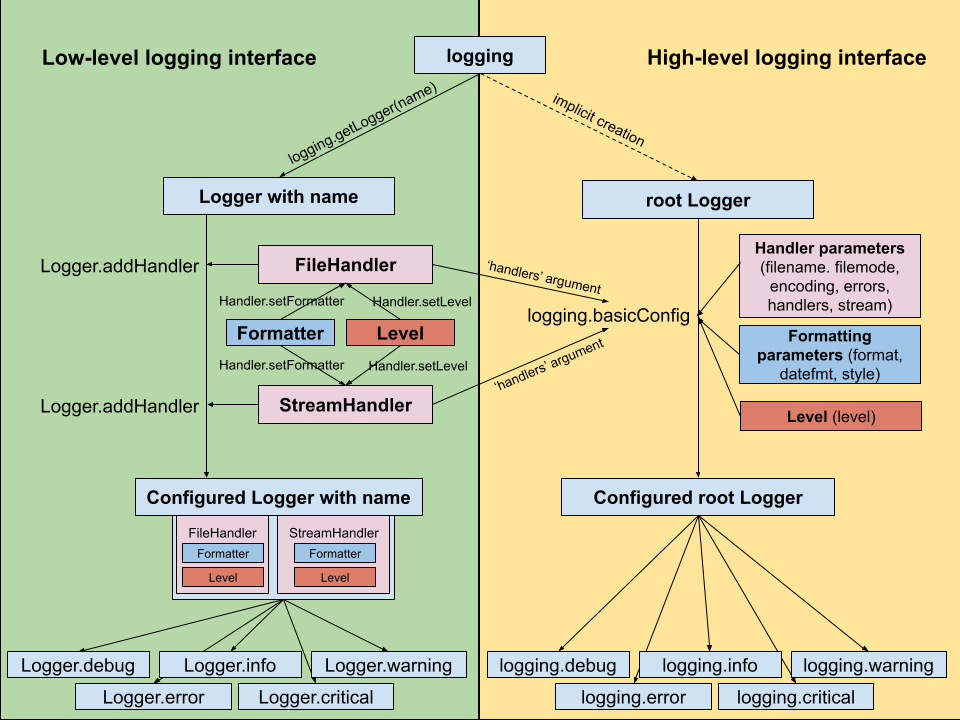

### Ещё немного про уровни логирования

На самом деле уровней логирования бывает бесконечное количество. 0 уровень, 1 уровень, 2 уровень, 3 уровень и так далее, но для простоты использования наиболее распространённым уровням были даны имена. `DEBUG = 10`, `INFO = 20`, `WARNING = 30`, `ERROR = 40`, `CRITICAL = 50`

Даже в модуле `logging` за переменными `logging.<LEVEL>` скрываются просто числа

In [47]:
logging.DEBUG, logging.INFO, logging.WARNING, logging.ERROR, logging.CRITICAL

(10, 20, 30, 40, 50)

Это также означает, что в любом месте, где требуется `level`, можно указывать числа

In [48]:
logger = logging.Logger("my_logger")
handler = logging.StreamHandler(stream=sys.stderr)
handler.setLevel(49)    # <<<<
handler.setFormatter(logging.Formatter(fmt="Level {levelname}: {message}", style='{'))
logger.addHandler(handler)

In [49]:
logger.error("Error")   # Эта строка НЕ логируется, так как уровень Handler'а выше, чем у ERROR (49 > 40)
logger.critical("Critical")   # Эта строка логируется, так как уровень Handler'а ниже, чем у CRITICAL (49 < 50)

Level CRITICAL: Critical


Библиотеки для логирования таже позволяют нам создавать логи абсолютно с любым уровнем. В `logging` это делается при помощи функции `logging.log` или метода `Logger.log`, которые позволяют указать любой уровень

In [50]:
logger.log(level=48, msg="Important log message")
logger.log(level=50, msg="Super important log message")

Level CRITICAL: Super important log message


### Логирование объектов и исключений

`logging` позволяет передавать в функции для логирования не только строки, но и вообще любые объекты. Работает это также как и `print` (у объектов должен быть метод `__str__`)


In [51]:
import requests


logging.error({"a": 1, "b": 2})
logging.error(5345345345)
logging.error(requests.get("https://google.com"))

ERROR❗❗❗ 2024-04-04 13:04:27,886 🌞 {'a': 1, 'b': 2}
ERROR❗❗❗ 2024-04-04 13:04:27,887 🌞 5345345345
DEBUG❗❗❗ 2024-04-04 13:04:27,926 🌞 Starting new HTTPS connection (1): google.com:443
DEBUG❗❗❗ 2024-04-04 13:04:28,168 🌞 https://google.com:443 "GET / HTTP/1.1" 301 220
DEBUG❗❗❗ 2024-04-04 13:04:28,172 🌞 Starting new HTTPS connection (1): www.google.com:443
DEBUG❗❗❗ 2024-04-04 13:04:28,457 🌞 https://www.google.com:443 "GET / HTTP/1.1" 200 None
ERROR❗❗❗ 2024-04-04 13:04:28,463 🌞 <Response [200]>


Интересный факт! При логировании `requests.get` нашим логгером в вывод также "просочились" подкапотные логи `requests`, так как они тоже реализованы через `logging`, а поскольку мы изменяли свойства `root Logger`а, который является общим для всего, что выполняется в нашем коде, эти изменения затронули и логи из `requests`

In [52]:
def a():
    b()
    
def b():
    c()
    
def c():
    d()
    
def d():
    raise RuntimeError("Just a random exception")
    

try:
    a()
except RuntimeError as exc:
    logging.error(exc, exc_info=True)
    logging.exception(exc)   # Полностью аналогично коду выше

ERROR❗❗❗ 2024-04-04 13:04:29,915 🌞 Just a random exception
Traceback (most recent call last):
  File "/tmp/ipykernel_3855/2386077047.py", line 15, in <module>
    a()
  File "/tmp/ipykernel_3855/2386077047.py", line 2, in a
    b()
  File "/tmp/ipykernel_3855/2386077047.py", line 5, in b
    c()
  File "/tmp/ipykernel_3855/2386077047.py", line 8, in c
    d()
  File "/tmp/ipykernel_3855/2386077047.py", line 11, in d
    raise RuntimeError("Just a random exception")
RuntimeError: Just a random exception
ERROR❗❗❗ 2024-04-04 13:04:29,917 🌞 Just a random exception
Traceback (most recent call last):
  File "/tmp/ipykernel_3855/2386077047.py", line 15, in <module>
    a()
  File "/tmp/ipykernel_3855/2386077047.py", line 2, in a
    b()
  File "/tmp/ipykernel_3855/2386077047.py", line 5, in b
    c()
  File "/tmp/ipykernel_3855/2386077047.py", line 8, in c
    d()
  File "/tmp/ipykernel_3855/2386077047.py", line 11, in d
    raise RuntimeError("Just a random exception")
RuntimeError: Just a r

### Ротация логов

Если в вашей программе много логов и вы часто её запускаете, то в один момент файлы с логами начнут cтановиться слишком большими и с трудом открываться при помощи текстовых редакторов. Занимаемое файлом место можно ограничивать при помощи механизма, называемого **ротацией логов** (**logs rotation**).

Суть ротации заключается в том, что вы можете установить ограничения на размер файла с логами, а также ограничения на количество файлов. В `logging` это реализуется при помощи специального `Handler`а &mdash; `logging.handlers.RotatingFileHandler`

In [53]:
logger = logging.Logger("my_logger_with_rotation")
handler = logging.handlers.RotatingFileHandler("rotating_logs.log", maxBytes=100, backupCount=5)   # Каждый файл размером не более 100 байт, не более 5 файлов
handler.setLevel(logging.WARNING)
handler.setFormatter(logging.Formatter(fmt="Level {levelname}: {message}", style='{'))
logger.addHandler(handler)

In [54]:
for _ in range(20):
    logger.error("fhsd;hfgdhgdjfghd;kfjghdfk;ghdfklghdklsfghldsfkg")

## Модуль `loguru`

Модуль [`loguru`](https://loguru.readthedocs.io/en/stable/overview.html#overview) не входит в состав стандартной библиотеки и его нужно сначала установить. Он удобен тем, что имеет хорошее и красивое форматирование логов "из коробки"

В `loguru` не нужно отдельно создавать `Handler`ы, `Logger`ы, `Formatter`ы и так далее. Для всех операций используется `Logger` по-умолчанию (`loguru.logger`). Для добавления `Handler`а в логгер используется всего один метод `logger.add`

Файл/поток, ротация, форматирование, уровень для `Handler`а устанавливаются в одном месте. Форматирование немного отличается от `logging`, к тому же `loguru` позволяет задавать цвета для элементов. [Пояснения по форматированию есть в документации](https://loguru.readthedocs.io/en/stable/api/logger.html) (раздел "The record dict")

Исключения можно логировать при помощи `logger.opt(exception=True)` &mdash; данный метод возвращает объект, который умеет правильно логировать исключения, `logger.exception`, а также можно декорировать функцию декоратором `@logger.catch`, в таком случае все исключения внутри функции будут автоматически логироваться. Все перечисленные способы равноценны

Для большинства случаев я советую использовать `loguru`, так как она сильно проще в настройке, но про `logging` тоже не стоит забывать, так как она всё ещё используется во многих проектах

In [55]:
import sys

from loguru import logger

In [56]:
logger.debug("Debug message")
logger.info("Info message")
logger.warning("Warning message")
logger.error("Error message")
logger.critical("Critical message")
logger.success("Success message")
logger.log(100500, "Custom level message")

2024-04-04 13:04:51.434 | DEBUG    | __main__:<module>:1 - Debug message
2024-04-04 13:04:51.436 | INFO     | __main__:<module>:2 - Info message
2024-04-04 13:04:51.437 | WARNING  | __main__:<module>:3 - Warning message
2024-04-04 13:04:51.437 | ERROR    | __main__:<module>:4 - Error message
2024-04-04 13:04:51.438 | CRITICAL | __main__:<module>:5 - Critical message
2024-04-04 13:04:51.438 | SUCCESS  | __main__:<module>:6 - Success message
2024-04-04 13:04:51.439 | Level 100500 | __main__:<module>:7 - Custom level message


In [57]:
logger.remove(0)    # Удалить Handler по-умолчанию

logs_format = '<green>{time:YYYY-MM-DD HH:mm:ss.SSS}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - <level>{message}</level>'
logger.add(       # Добавляем Handler для записи в stdout
    sys.stdout,
    level="DEBUG",
    format=logs_format,
    colorize=True
)
logger.add(       # Добавляем Handler для записи всех логов в файл all_logs.log
    "all_logs.log",
    level=0,
    format=logs_format,
    colorize=False,
    rotation="1 week"
)
logger.add(       # Добавляем Handler для записи ошибок в файл errors_logs.log
    "errors_logs.log",
    level=29,
    format=logs_format,
    colorize=False,
    rotation="500 B"
)

3

In [58]:
logger.debug("Debug message")
logger.info("Info message")
logger.warning("Warning message")
logger.error("Error message")
logger.critical("Critical message")
logger.success("Success message")
logger.log(100500, "Custom level message")

2024-04-04 13:04:53.303 | DEBUG    | __main__:<module>:1 - Debug message
2024-04-04 13:04:53.315 | INFO     | __main__:<module>:2 - Info message
2024-04-04 13:04:53.316 | WARNING  | __main__:<module>:3 - Warning message
2024-04-04 13:04:53.322 | ERROR    | __main__:<module>:4 - Error message
2024-04-04 13:04:53.323 | CRITICAL | __main__:<module>:5 - Critical message
2024-04-04 13:04:53.324 | SUCCESS  | __main__:<module>:6 - Success message
2024-04-04 13:04:53.325 | Level 100500 | __main__:<module>:7 - Custom level message


## Полезные ссылки

+ [Статья на хабре про модуль `logging`](https://habr.com/ru/companies/wunderfund/articles/683880/)
+ [Подробная статья про аргументы CL в целом и python в частности](https://realpython.com/python-command-line-arguments/)

# Тестирование

**Тестирование** - процесс исследования и испытания программного продукта *Цель* тестирования - проверка соотвествия между реальным и ожидаемым поведением программы.


Процесс тестирования состоит из *тестовых сценариев* (test case). Каждый сценарий состоит из *предусловий* (preconditions), *шагов* (steps) и *ожидаемого результата* (expected result).

**Покрытие кода** (code coverage) - формальная метрика, которая показывает процент исходного кода программы, который выполняется в процессе тестирования, то есть покрыт тестами. 

При этом покрытие обычно считается не по-символьно, а по структурным элементам: покрытие операторов, условий, функций, покрытие значений параметров.

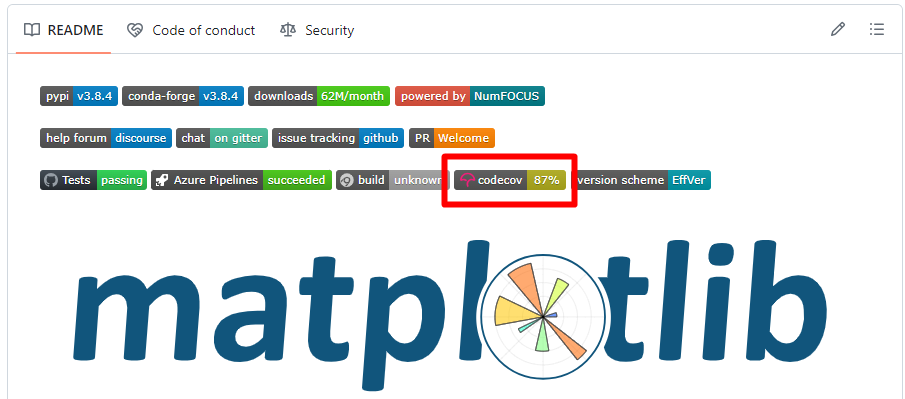

Некоторые важные принципы:

+ Тестирование только снижает вероятность наличия дефектов, которые находятся в программном обеспечении, но не гарантирует их отсутствия.
+ Полное тестирование с использованием всех входных комбинаций данных, результатов и предусловий физически невыполнимо (исключение — тривиальные случаи).
+ Следует начинать тестирование на ранних стадиях жизненного цикла разработки ПО, чтобы найти дефекты как можно раньше.
+ Большая часть дефектов находится в ограниченном количестве модулей.
+ Тестирование проводится по-разному в зависимости от контекста. Например, программное обеспечение, в котором критически важна безопасность, тестируется иначе, чем новостной портал.
+ Отсутствие найденных дефектов при тестировании не всегда означает готовность продукта к релизу. Система должна быть удобна пользователю в использовании и удовлетворять его ожиданиям и потребностям.

## Классификация тестов

#### Классификация по доступу к коду и архитектуре:
+ Тестирование белого ящика — метод тестирования ПО, который предполагает полный доступ к коду проекта.
+ Тестирование серого ящика — метод тестирования ПО, который предполагает частичный доступ к коду проекта (комбинация White Box и Black Box методов).
+ Тестирование чёрного ящика — метод тестирования ПО, который не предполагает доступа (полного или частичного) к системе. Основывается на работе исключительно с внешним интерфейсом тестируемой системы.

#### Классификация по уровню детализации приложения:
+ Модульное тестирование (unit tests) — проводится для тестирования какого-либо одного логически выделенного и изолированного элемента (модуля) системы в коде. Проводится самими разработчиками, так как предполагает полный доступ к коду.
+ Интеграционное тестирование — тестирование, направленное на проверку корректности взаимодействия нескольких модулей, объединенных в единое целое.
+ Системное тестирование — процесс тестирования системы, на котором проводится не только функциональное тестирование, но и оценка характеристик качества системы — ее устойчивости, надежности, безопасности и производительности.
+ Приёмочное тестирование — проверяет соответствие системы потребностям, требованиям и бизнес-процессам пользователя.

#### Классификация по степени автоматизации:
+ Ручное тестирование.
+ Автоматизированное тестирование.

#### Классификация по принципам работы с приложением
+ Позитивное тестирование — тестирование, при котором используются только корректные данные.
+ Негативное тестирование — тестирование приложения, при котором используются некорректные данные и выполняются некорректные операции.

#### Классификация по уровню функционального тестирования:
+ Дымовое тестирование (smoke test) — тестирование, выполняемое на новой сборке, с целью подтверждения того, что программное обеспечение стартует и выполняет основные для бизнеса функции.
+ Тестирование критического пути (critical path) — направлено для проверки функциональности, используемой обычными пользователями во время их повседневной деятельности.
+ Расширенное тестирование (extended) — направлено на исследование всей заявленной в требованиях функциональности.

#### Классификация в зависимости от исполнителей:
+ Альфа-тестирование — является ранней версией программного продукта. Может выполняться внутри организации-разработчика с возможным частичным привлечением конечных пользователей.
+ Бета-тестирование — программное обеспечение, выпускаемое для ограниченного количества пользователей. Главная цель — получить отзывы клиентов о продукте и внести соответствующие изменения.


#### Классификация по запуску кода на исполнение:
+ Статическое тестирование — процесс тестирования, который проводится для верификации практически любого артефакта разработки: программного кода компонент, требований, системных спецификаций, функциональных спецификаций, документов проектирования и архитектуры программных систем и их компонентов.
+ Динамическое тестирование — тестирование проводится на работающей системе, не может быть осуществлено без запуска программного кода приложения.


В python ключевым оператором, который нужен для проверки ожиданий и реальности является оператор `assert`. Он позволяет в случае отрицательного (с точки зрения булевых значений) результата бросить ошибку. При чем это конкретная ошибка `AssertionError`, которая обычно имеет смысл несовпадения результатов и ожиданий.

In [4]:
assert True

In [5]:
assert False

AssertionError: 

Но обычно в `assert` передают какое-то булево условие (`condition`)

In [6]:
assert sum([1, 2, 4]) == 6

AssertionError: 

Также через `,` можно передать специальный текст, который будет выведен в случае ошибки. Для особо внимательных, да, это получается `assert` пиринимает кортеж

In [7]:
assert sum([1, 2, 4]) == 6, "Should be 6"

AssertionError: Should be 6

Если все было правильно, `assert` никак не влияет на всю остальную работу в программе

In [9]:
assert sum([1, 2, 3]) == 6, "Should be 6"

мы с вами здесь рассмотрим только самые простые примеры модульного тестирование

## Модульное тестирование (unit tests)

В python существует несколько библиотек для модульного тестирования. При этом общим местом (не только для питона) является то, что все что связано с тестированием (файл с тестами, класс с тестами, функция-тест, ...) называются со слова `test_` или `Test`.



Самые популярные из них это: `unittest` и `pytest`. Как это часто бывает, `pytest` более модная, а `unittest` более классическая.


### `unittest`

Самая базовая библиотека. Многие другие, добавляя более крутой функционал, стараются сохранять совместимость с `unittest`. 

Все строится на основе классов, которые должны наследоваться от `unittest.TestCase`. Методы в вашем классе, которые называются с `test_` - это тесты которые будут выполнены

In [11]:
%%file test_script.py
import unittest

class TestSum(unittest.TestCase):

    def test_sum(self):
        self.assertEqual(sum([1, 2, 3]), 6, "Should be 6")

    def test_sum_tuple(self):
        self.assertEqual(sum((1, 2, 2)), 6, "Should be 6")

if __name__ == '__main__':
    unittest.main()

Writing test_script.py


In [13]:
! python test_script.py

.F
FAIL: test_sum_tuple (__main__.TestSum.test_sum_tuple)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/mnt/c/Users/vauli/Documents/Study/BI/Python/Lectures/Notebooks/test_script.py", line 9, in test_sum_tuple
    self.assertEqual(sum((1, 2, 2)), 6, "Should be 6")
AssertionError: 5 != 6 : Should be 6

----------------------------------------------------------------------
Ran 2 tests in 0.002s

FAILED (failures=1)


При этом на самом деле для запуска тестов просто вызывают `unittest` в директории проекта и `unittest` прогонит все тесты (все методы классов начинающиеся с `test_`) во всех модулях с тестами (файлы с `test_` в текущей директории или в папках с `test_`)

In [16]:
! python -m unittest

.F
FAIL: test_sum_tuple (test_script.TestSum.test_sum_tuple)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/mnt/c/Users/vauli/Documents/Study/BI/Python/Lectures/Notebooks/test_script.py", line 9, in test_sum_tuple
    self.assertEqual(sum((1, 2, 2)), 6, "Should be 6")
AssertionError: 5 != 6 : Should be 6

----------------------------------------------------------------------
Ran 2 tests in 0.002s

FAILED (failures=1)


### `pytest`

`pytest` устроен нескольно иначе. Ключевым элементом в нем тестирующая функция. Хотя при этом можно объединять функции в классы чтобы поддерживать структуру.

In [17]:
%%file test_script.py
def test_sum():
    assert sum([1, 2, 3]) == 6, "Should be 6"

def test_sum_tuple():
    assert sum((1, 2, 2)) == 6, "Should be 6"

Overwriting test_script.py


In [18]:
! python -m pytest

============================= test session starts ==============================
platform linux -- Python 3.12.1, pytest-7.4.3, pluggy-1.3.0
rootdir: /mnt/c/Users/vauli/Documents/Study/BI/Python/Lectures/Notebooks
plugins: anyio-3.7.1
collected 2 items                                                              

test_script.py .F                                                        [100%]

=================================== FAILURES ===================================
________________________________ test_sum_tuple ________________________________

    def test_sum_tuple():
>       assert sum((1, 2, 2)) == 6, "Should be 6"
E       AssertionError: Should be 6
E       assert 5 == 6
E        +  where 5 = sum((1, 2, 2))

test_script.py:5: AssertionError
=========================== short test summary info ============================
FAILED test_script.py::test_sum_tuple - AssertionError: Should be 6
========================= 1 failed, 1 passed in 0.18s ==========================


### Пример тестирования проекта

Здесь все будет обсуждаться в лекции, но тут вы можете посмотреть на имеющийся код.

Пусть в директории проекта имеются следующие файлы:

`biotools.py`

In [ ]:
DNA = {"A", "T", "G", "C"}
RNA = {"A", "U", "G", "C"}

TranscriptionMap = {
    "a": "a", "A": "A",
    "t": "u", "T": "U",
    "u": "t", "U": "T",
    "g": "g", "G": "G",
    "c": "c", "C": "C",
    "n": "n", "N": "N"
}

ComplementDNAMap = {
    "a": "t", "A": "T",
    "t": "a", "T": "A",
    "g": "c", "G": "C",
    "c": "g", "C": "G",
    "n": "n", "N": "N"
}

ComplementRNAMap = {
    "a": "u", "A": "U",
    "u": "a", "U": "A",
    "g": "c", "G": "C",
    "c": "g", "C": "G",
    "n": "n", "N": "N"
}

def is_dna(seq):
    return set(seq.upper()) <= DNA

def is_rna(seq):
    return set(seq.upper()) <= RNA

def transcribe(seq):
    if is_dna(seq) and is_rna(seq):
        raise ValueError
    return ''.join([TranscriptionMap[i] for i in seq])

def reverse(seq):
    return seq[::-1]

def complement(seq):
    if is_dna(seq) and not is_rna(seq):
        result = ''.join([ComplementDNAMap[i] for i in seq])
    elif is_rna(seq) and not is_dna(seq):
        result = ''.join([ComplementRNAMap[i] for i in seq])
    else: 
        raise ValueError
    return result

def reverse_complement(seq):
    if is_dna(seq) and is_rna(seq):
        raise ValueError
    return complement(reverse(seq))

def write_fasta(id_, description, sequence, file_path):
    with open(file_path, 'w') as fasta_file:
        fasta_string = f'>{id_} {description}\n{sequence}'
        fasta_file.write(fasta_string)

def read_fasta(file_path):
    with open(file_path, 'r') as fasta_file:
        line = fasta_file.readline().strip().strip('>')
        id_, description = line.split(' ', 1)
        sequence = fasta_file.readline().strip()
    return id_, description, sequence

`test_biotools_unittest.py`

In [ ]:
import unittest
import os

from biotools import DNA, reverse_complement, write_fasta


class TestDNA(unittest.TestCase):

    def test_len(self):
        target = 4
        result = len(DNA)
        self.assertEqual(target, result)

    def test_content(self):
        target = {'A', 'T', 'G', 'C'}
        result = DNA
        self.assertSetEqual(target, result)
        
class TestReverseComplement(unittest.TestCase):

    def test_reverse_complement_dna2dna(self):
        inp = 'ATGC'
        target = 'GCAT'
        result = reverse_complement(inp)
        self.assertEqual(target, result)

    def test_reverse_complement_dna2rna(self):
        inp = 'ATGCU'
        with self.assertRaises(ValueError):
            reverse_complement(inp)
            
class TestWriteFasta(unittest.TestCase):
    def setUp(self):
        self.inp = ('1', 'Descr descr', 'ATGC')
    
    def tearDown(self):
        try:
            os.remove('tmp.fasta')
        except FileNotFoundError:
            pass 
    
    def test_write_fasta_exists(self):
        write_fasta(*self.inp, 'tmp.fasta')
        self.assertTrue(os.path.exists('tmp.fasta'))
        
    def test_write_fasta_content(self):
        write_fasta(*self.inp, 'tmp.fasta')
        
        with open('tmp.fasta', 'r') as file:
            line = file.readline().strip().strip('>')
            id_, description = line.split(' ', 1)
            sequence = file.readline().strip()  
        result = (id_, description, sequence)
        self.assertTupleEqual(self.inp, result)

`test_biotools_pytest.py`

In [ ]:
import os
import pytest

from biotools import DNA, reverse_complement, write_fasta

def test_dna_len():
    target = 4
    result = len(DNA)
    assert target == result

def test_dna_content():
    target = {'A', 'T', 'G', 'C'}
    result = set(DNA)
    assert target == result

def test_reverse_complement_dna2dna():
    inp = 'ATGC'
    target = 'GCAT'
    result = reverse_complement(inp)
    assert target == result

def test_reverse_complement_dna2rna():
    inp = 'ATGCU'
    with pytest.raises(ValueError):
        reverse_complement(inp)

@pytest.fixture
def input_data():
    return ('1', 'Descr descr', 'ATGC')

@pytest.fixture
def tmp_file():
    file_path = 'tmp.fasta'
    yield file_path
    if os.path.exists(file_path):
        os.remove(file_path)

def test_write_fasta_exists(input_data, tmp_file):
    write_fasta(*input_data, tmp_file)
    assert os.path.exists(tmp_file)

def test_write_fasta_content(input_data, tmp_file):
    write_fasta(*input_data, tmp_file)
    
    with open(tmp_file, 'r') as file:
        line = file.readline().strip().strip('>')
        id_, description = line.split(' ', 1)
        sequence = file.readline().strip()  
    result = (id_, description, sequence)
    
    assert input_data == result
